Title:VIT_for_APSremoval   
Author: Luke Fairbanks     

Credit: Yuri Fialko for project guidance & data; https://sioviz.ucsd.edu/~fialko/     
---the original training data for this ML model was from some matlab code of his meant to replicate APS (atmospherica phase screen) noise in InSAR images     
---the testing/development dataset is relatively simple, 40x40 images with two classes (datm - signal and noise, gatm - noise)   
---where the signal is a simple gaussian bump & the noise is randomized spatial noise across the pixels of the image, obscurring the underlying signal   
---one of key points is that this noise screen varies with time whereas the underlying signal is expected to be a more persistent signal wrt time  
---hence the structure of the ML model to take advantage of 'multiplicity' parameter to simulate 'moving window' of data    

Credit: Pytorch libraries & others which form basis for model; https://pytorch.org/     

Credit: https://github.com/lucidrains/vit-pytorch authors & the parent libraries they pull from;      
--they organized a host of ViT architectures as examples, these example files should be in the 'vit_pytorch' folder, more info at bottom     
--my ViT is different in some fundamental ways, namely it does not do classification but rather filtration/transform    
---the whole point is to take InSAR images, or in this case test images, and identify the persistent signal (fault line movement of Earth's crust)   
---where the noise over the image 

--effectively what my model does is take as input an image which has signal and noise, passes the image through a visual transfromer, the compares the output, the transformed image, to the residual signal which is SignalAndNoise - Noise data    
--comparison is done via MSE across the pixel values, where model(SignalAndNoise) and Residues have same dimensionality   
--then this MSE loss is used as the model training loss   

--code is structured to create proper dimensions but for clarity tensors have dimensionality (batchNum, channelNum, IMGheight, IMGwidth)   
--I'm going to try & automate as much as I can, and will show where user input is expected to best of my ability   
--goal is to minimize it down to data folder root address input and parameter inputs   

--'multiplicity' is an important parameter to use methodology of CSS (APS removal) since it simulates taking 1 resuidue/signal image(long lasting in time), and re-sampling spatial noise across the corresponding SignalAndNoise image   
--the whole idea being one may increase 'multiplicity' (integer), increasing channelNum of tensor, allowing model to train/test on arbitrary length (temporal-simulated/noise-resampled) sequences of images   
--this procedure effectively allows ViT model to look at 'moving window' of data as if from previous N=multiplicity image snapshots to extract the long lasting features of the image   
--pixel variance of original SignalAndNoise image is used to re-sample noise w/ pytorch methods,    

--check last section for more details on 'what next?'    
--after you've got the code running on example data provided, please continue running cells   
--contact Luke Fairbanks for questions; otherwise try code debuggers or chatbot-assisted debug/testing, pytorch/torchvision documentation, example code from git/lucidrains & other similar projects, etc...     


If you wish to run the code on simply the example data and get a nice 'clean run' of the code, please load imports below, run the function/class definition block, then proceed to [section 4] to train the model via the function 'trainModelFromScratch'    

--Cheers   

In [1]:
#imports
#please run & continue or download libraries used via PIP or other methods

import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform

import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

from einops import rearrange
from einops.layers.torch import Rearrange

import xarray as xr
from PIL import Image

import shutil

import imageio

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

The following code block encapsulates all functions

##############################################################################################################################################################


[section 1]  

The first code (top of cell above and immediately below) regard pre-processing data    
This code assumes output from the fake_igrams.m file, namely sets of images in subdirectories datm(noise+signal)/gatm(noise) OR 'raw' images paired with CSS result images     
You should be able to simply SPECIFY      
-your data address folder within 'USER_fake_igrams_address' or change the example code address DEFAULT_DATM_GATM_ROOTaddress to the root where data is stored  
----easier to just modify DEFAULT_DATM_GATM_ROOTaddress
-image dimensions with (x,y,channelNum with imgDim)   
-modify

If using 'real' data, would assume only having Signal+Noise, and possibly a CSS stack result as the best standardized approximation of underlying signal    
in this case,     
---use raw images as SignalAndNoise images (datm) and subtact CSS result from SignalAndNoise to make substitue for noise (gatm), use [load data function], [matrix arithmetic function], and [save data into datm/gatm format function] to perform this operation    
---OR use the CSS result as the Residue = SignalAndNoise - Noise, and proceed to the machine learning section (2) of the code by running [function to organize SignalAndNoise and Residue for training].     

Make sure to run the definitions of classes and functions immediately below & proceed to model training after prepping data    

The code immediately below is included for clarity about data prep process; however, for example code and use one may proceed to 'trainModelFromScratch' call

##############################################################################################################################################################


[section 2]

The second block of code in definitions^ regards the machine learning model
You should be able to simply run the code & proceed to training

##############################################################################################################################################################


[section 3]

functions to help user plot things and save results

##############################################################################################################################################################


please run the code block & once successful proceed to  [section 4] to run the data-prep, training, and plotting

In [10]:
###########################################################################################################################################################################
#helper functions


#loader to get datm/gatm address & return allNoise, allSignalNoise, allResidues np arrays
def DATM_GATM_loader_NParrays(DATM_GATM_address, imgDimensions):    #example input DEFAULT_DATM_GATM_address, imgDimensions = [x,y,channel=1(greyscale)]
    folderNoise = DATM_GATM_address + 'gatm\\'  ##noise only = gatm
    folderSignalandNoise = DATM_GATM_address + 'datm\\' ##signal+noise = datm
    filesSN = os.listdir(folderSignalandNoise) #list of the files
    filesN = os.listdir(folderNoise)
    filesSN = [file for file in filesSN if os.path.isfile(os.path.join(folderSignalandNoise, file))]
    filesN = [file for file in filesN if os.path.isfile(os.path.join(folderNoise, file))]
    img_rows, img_cols, channels = imgDimensions  #define parameters for image size
    allNoise = np.zeros((img_rows, img_cols,len(filesN)))   # create numpy arrays to store all images from the folders
    allSignalNoise = np.zeros((img_rows, img_cols,len(filesSN))) 
    #loops to fill the allNoise and allSignalNoise arrays with the image data, this is done for testing, but also since it's easy to then convert these to png files for the pytorch/torchvision training
    count=0
    for file in filesN:
        pathNow = folderNoise + file
        filNow = xr.open_dataset(pathNow, engine='netcdf4')
        Znow = filNow['z']
        allNoise[:,:,count] = Znow
        count += 1    
    count=0
    for file in filesSN:
        pathNow = folderSignalandNoise + file
        filNow = xr.open_dataset(pathNow, engine='netcdf4')
        Znow = filNow['z']
        allSignalNoise[:,:,count] = Znow
        count += 1 
    #create an array to store the residual data => the signal    
    allResidues = allSignalNoise - allNoise   
    return allNoise, allSignalNoise, allResidues


def RAW_CSS_loader_NParrays(root_address, imgDimensions):
    folderSignalandNoise = DATM_GATM_address + 'raw\\' ##signal+noise = RAW
    folderResidues = DATM_GATM_address + 'css\\' ##residue = CSS stack result = approximation of interferomatric signal image
    filesSN = os.listdir(folderSignalandNoise) #list of the files
    filesR = os.listdir(folderResidues)
    filesSN = [file for file in filesSN if os.path.isfile(os.path.join(folderSignalandNoise, file))]
    filesN = [file for file in filesN if os.path.isfile(os.path.join(folderNoise, file))]
    filesR = [file for file in filesR if os.path.isfile(os.path.join(folderResidues, file))]
    img_rows, img_cols, channels = imgDimensions  #define parameters for image size
    allSignalNoise = np.zeros((img_rows, img_cols,len(filesSN))) 
    allResidues = np.zeros((img_rows, img_cols,len(filesSN)))
    #loops to fill the allNoise and allSignalNoise arrays with the image data, this is done for testing, but also since it's easy to then convert these to png files for the pytorch/torchvision training   
    count=0
    for file in filesSN:
        pathNow = folderSignalandNoise + file
        filNow = xr.open_dataset(pathNow, engine='netcdf4')
        Znow = filNow['z']
        allSignalNoise[:,:,count] = Znow
        count += 1 
    count=0
    for file in filesR:
        pathNow = folderResidues + file
        filNow = xr.open_dataset(pathNow, engine='netcdf4')
        Znow = filNow['z']
        allResidues[:,:,count] = Znow
        count += 1
    #create an array to store the residual data => the signal      
    allNoise = allSignalNoise - allResidues
    return allNoise, allSignalNoise, allResidues


# Function to normalize an array and convert it to uint8
def normalize_and_convert(array):
    array = (array - np.min(array)) / (np.max(array) - np.min(array)) * 255
    return array.astype('uint8')


#loader to get datm/gatm address & prepare the directory for use in pytorch
def directoryPrep(DATM_GATM_address, imgDimensions, setting = 'DATM_GATM'):
    if setting == 'RAW_CSS':
        allNoise, allSignalNoise, allResidues = RAW_CSS_loader_NParrays(DATM_GATM_address, imgDimensions)
    elif setting == 'DATM_GATM':
        allNoise, allSignalNoise, allResidues = DATM_GATM_loader_NParrays(DATM_GATM_address, imgDimensions)
    #count the number of images of each type; noise, signal+noise, and residue
    #should be equal
    nCount = allNoise.shape[2]
    snCount = allSignalNoise.shape[2]
    rCount = allResidues.shape[2] 
    #organize process of saving images as png in the home directory, in a structure which works well with pytorch data loader
    folderBase = DATM_GATM_address  #'D:\\Research\\Yuri Fialko\\set 2\\'
    nSub = 'NoisePng\\'
    snSub = 'SignalNoisePng\\'
    rSub = 'ResiduePng\\'
    allFolder = folderBase + 'Png_n_sn_r\\'
    nSubFull = folderBase + nSub
    snSubFull = folderBase + snSub
    rSubFull = folderBase + rSub
    #create directories if they do not exist yet
    if not os.path.exists(nSubFull):
        os.makedirs(nSubFull)
    if not os.path.exists(snSubFull):
        os.makedirs(snSubFull)
    if not os.path.exists(rSubFull):
        os.makedirs(rSubFull)
    if not os.path.exists(allFolder):
        os.makedirs(allFolder)
    # Save the images as PNG files
    for i in range(nCount):
        imgNow = allNoise[:,:,i]
        imgNow = normalize_and_convert(imgNow)
        imgNow2 = Image.fromarray(imgNow.astype('uint8'))
        imgNow2.save(nSubFull + 'n' + str(i) + '.png')
        imgNow2.save(allFolder + 'n' + str(i) + '.png')
    for i in range(snCount):
        imgNow = allSignalNoise[:,:,i]
        imgNow = normalize_and_convert(imgNow)
        imgNow2 = Image.fromarray(imgNow.astype('uint8'))
        imgNow2.save(snSubFull + 'sn' + str(i) + '.png')
        imgNow2.save(allFolder + 'sn' + str(i) + '.png')
    for i in range(rCount):
        imgNow = allResidues[:,:,i]
        imgNow = normalize_and_convert(imgNow)
        imgNow2 = Image.fromarray(imgNow.astype('uint8'))
        imgNow2.save(rSubFull + 'r' + str(i) + '.png')
        imgNow2.save(allFolder + 'r' + str(i) + '.png')
    print('Directories should be prepped with PNG files now')
    return None
    
    
#function to load in data from a folder with all the png files together, namely the folder saved previously "allFolder = folderBase + 'Png_n_sn_r\\'"    
def organize_images_for_torchvision_APS(directory, train_test_split=0.8):
    # Create directories for the classes in train and test
    PNGallFolder =  directory+'Png_n_sn_r\\'
    os.makedirs(os.path.join(PNGallFolder, 'train', 'class_0'), exist_ok=True)   #class_0 = residues
    os.makedirs(os.path.join(PNGallFolder, 'train', 'class_1'), exist_ok=True)   #class_1 = signal+noise
    os.makedirs(os.path.join(PNGallFolder, 'train', 'class_2'), exist_ok=True)   #class_2 = noise
    os.makedirs(os.path.join(PNGallFolder, 'test', 'class_0'), exist_ok=True)
    os.makedirs(os.path.join(PNGallFolder, 'test', 'class_1'), exist_ok=True)
    os.makedirs(os.path.join(PNGallFolder, 'test', 'class_2'), exist_ok=True)
    # Create a list of filenames for each class
    filenames_class_0 = [filename for filename in os.listdir(PNGallFolder) if filename.endswith('.png') and 'r' in filename]
    filenames_class_1 = [filename for filename in os.listdir(PNGallFolder) if filename.endswith('.png') and 'sn' in filename]
    filenames_class_2 = [filename for filename in os.listdir(PNGallFolder) if filename.endswith('.png') and 'r' not in filename and 'sn' not in filename]
    # Sort the filenames
    filenames_class_0.sort()
    filenames_class_1.sort()
    filenames_class_2.sort()
    # Calculate the train/test split index for each class
    split_index_class_0 = int(len(filenames_class_0) * train_test_split)
    split_index_class_1 = int(len(filenames_class_1) * train_test_split)
    split_index_class_2 = int(len(filenames_class_2) * train_test_split)
    # Split the filenames into train and test for each class
    train_filenames_class_0 = filenames_class_0[:split_index_class_0]
    test_filenames_class_0 = filenames_class_0[split_index_class_0:]
    train_filenames_class_1 = filenames_class_1[:split_index_class_1]
    test_filenames_class_1 = filenames_class_1[split_index_class_1:]
    train_filenames_class_2 = filenames_class_2[:split_index_class_2]
    test_filenames_class_2 = filenames_class_2[split_index_class_2:]
    # Move files to the appropriate class directories in the train folder
    for filename in train_filenames_class_0:
        shutil.move(os.path.join(PNGallFolder, filename), os.path.join(PNGallFolder, 'train', 'class_0', filename))
    for filename in train_filenames_class_1:
        shutil.move(os.path.join(PNGallFolder, filename), os.path.join(PNGallFolder, 'train', 'class_1', filename))
    for filename in train_filenames_class_2:
        shutil.move(os.path.join(PNGallFolder, filename), os.path.join(PNGallFolder, 'train', 'class_2', filename))
    # Move files to the appropriate class directories in the test folder
    for filename in test_filenames_class_0:
        shutil.move(os.path.join(PNGallFolder, filename), os.path.join(PNGallFolder, 'test', 'class_0', filename))
    for filename in test_filenames_class_1:
        shutil.move(os.path.join(PNGallFolder, filename), os.path.join(PNGallFolder, 'test', 'class_1', filename))
    for filename in test_filenames_class_2:
        shutil.move(os.path.join(PNGallFolder, filename), os.path.join(PNGallFolder, 'test', 'class_2', filename))
    return None    


def loaderFULL(root_address, imgDimensions, train_test_ratio=0.8, setting='DATM_GATM'):
    if setting == 'DATM_GATM':
        directoryPrep(root_address, imgDimensions, setting)
        organize_images_for_torchvision_APS(root_address, train_test_split=train_test_ratio)
    elif setting == 'RAW_CSS':
        directoryPrep(root_address, imgDimensions, setting)
        organize_images_for_torchvision_APS(root_address, train_test_split=train_test_ratio)
    print('Data should be prepped into train/test subdirectories with class directories within each for noise, signal, and residue classes of images')
    return None
    

###########################################################################################################################################################################


###########################################################################################################################################################################
#The following code block encapsulates the machine learning class architecture based on the simpleViT example from https://github.com/lucidrains/vit-pytorch
#my model changes are within the 'SimpleViTaps' class where I have changed the model from classification to filtration/transform
#i left all the original architecture intact since why not & also might help if one wants to utilize the other ViT model examples & modify any of them please refer to differences between SimpleViT and SimpleViTaps

"""
Note, the following SimpleViT architecture has been sourced from https://github.com/lucidrains/vit-pytorch
My modifications are encapsulated within 'SimpleViTaps' where I change the classification model to transform/filtration via model head change
such that rather than returning classification vectors model returns image tensor for     loss( model( SignalAndNoise) , Residual = SignalAndNoise - Noise) [MSE loss]


this is done within:

self.linear_head = nn.Linear(self.dim, self.channels * self.image_height * self.image_width)

x = self.linear_head(x)
x = x.view(-1, self.channels, self.image_height, self.image_width)
return x  


The CustomDatasetAPS is my creation, but heavily inspired by examples in pytorch references
It serves as the system to pick files from the train/test => class_0/class_1/class_2/... folders and load them via the pytorch dataloader for batch training
One of the important functions of my code is the use of 'multiplicity' parameter within this dataset class
Please refer to class definition or documentation at bottom of page for details and advice regarding use of multiplicity parameter and CustomDatasetAPS
Basic idea is that it takes single image sets with SignalAndNoise and Residual, resamples spatial noise abd creates new channels containing these resamples, extending tensor
Meant to simulate method of CSS since can stack up images with resampled noise to have ML model pick up on the long lasting feature of signal
"""

# helpers (functions)

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def posemb_sincos_2d(h, w, dim, temperature: int = 10000, dtype = torch.float32):
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij")
    assert (dim % 4) == 0, "feature dimension must be multiple of 4 for sincos emb"
    omega = torch.arange(dim // 4) / (dim // 4 - 1)
    omega = 1.0 / (temperature ** omega)
    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1)
    return pe.type(dtype)

# classes for simpleViT architecture

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self, x):
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head),
                FeedForward(dim, mlp_dim)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

class SimpleViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'
        patch_dim = channels * patch_height * patch_width
        self.to_patch_embedding = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )
        self.pos_embedding = posemb_sincos_2d(
            h = image_height // patch_height,
            w = image_width // patch_width,
            dim = dim,
        ) 
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)
        self.pool = "mean"
        self.to_latent = nn.Identity()
        self.linear_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        device = img.device
        x = self.to_patch_embedding(img)
        x += self.pos_embedding.to(device, dtype=x.dtype)
        x = self.transformer(x)
        x = x.mean(dim = 1)
        x = self.to_latent(x)
        return self.linear_head(x)

    
class SimpleViTaps(nn.Module):
    def __init__(self, *, image_size, patch_size, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64):
        super().__init__()
        self.image_height, self.image_width = pair(image_size)
        self.patch_height, self.patch_width = pair(patch_size)
        self.channels = channels
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.dim_head = dim_head
        assert self.image_height % self.patch_height == 0 and self.image_width % self.patch_width == 0, 'Image dimensions must be divisible by the patch size.'
        patch_dim = self.channels * self.patch_height * self.patch_width
        self.to_patch_embedding = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1 = self.patch_height, p2 = self.patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, self.dim),
            nn.LayerNorm(self.dim),
        )
        self.pos_embedding = posemb_sincos_2d(
            h = self.image_height // self.patch_height,
            w = self.image_width // self.patch_width,
            dim = self.dim,
        ) 
        self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim)
        self.pool = "mean"
        self.to_latent = nn.Identity()
        # Change this line to output a tensor with the same shape as the input
        self.linear_head = nn.Linear(self.dim, self.channels * self.image_height * self.image_width)

    def forward(self, img):
        device = img.device
        x = self.to_patch_embedding(img)
        x += self.pos_embedding.to(device, dtype=x.dtype)
        x = self.transformer(x)
        x = x.mean(dim = 1)
        x = self.to_latent(x)
        x = self.linear_head(x)
        # Reshape the output to match the input dimensions
        x = x.view(-1, self.channels, self.image_height, self.image_width)
        return x    
    
    
    
    
    
class CustomDatasetAPS(Dataset):
    def __init__(self, root_dir, transform=None, multiplicity=1):
        """
        Arguments:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample. In my code transformAPS is used, doesn't do much but left up to continued work of project to experiment there, check final notes section
        """
        self.root_dir = root_dir
        self.transform = transform
        self.subs1 = {'train': 'train\\', 'test': 'test\\'}
        self.subs2 = {'residues': 'class_0\\', 'SignalNoise': 'class_1\\', 'Noise': 'class_2\\'}
        self.FullPaths = {'TrainR': root_dir+self.subs1['train']+self.subs2['residues'],
                         'TestR': root_dir+self.subs1['test']+self.subs2['residues'],
                         'TrainSN': root_dir+self.subs1['train']+self.subs2['SignalNoise'],
                         'TestSN': root_dir+self.subs1['test']+self.subs2['SignalNoise'],
                         'TrainN': root_dir+self.subs1['train']+self.subs2['Noise'],
                         'TestN': root_dir+self.subs1['test']+self.subs2['Noise'],}
        self.TrainrFiles = os.listdir(self.FullPaths['TrainR'])
        self.TestrFiles = os.listdir(self.FullPaths['TestR'])
        self.TrainsnFiles = os.listdir(self.FullPaths['TrainSN'])
        self.TestsnFiles = os.listdir(self.FullPaths['TestSN'])
        self.TrainnFiles = os.listdir(self.FullPaths['TrainN'])
        self.TestnFiles = os.listdir(self.FullPaths['TestN'])
        self.TrainrFiles = [file for file in self.TrainrFiles if os.path.isfile(os.path.join(self.FullPaths['TrainR'], file))]
        self.TestrFiles = [file for file in self.TestrFiles if os.path.isfile(os.path.join(self.FullPaths['TestR'], file))]
        self.TrainsnFiles = [file for file in self.TrainsnFiles if os.path.isfile(os.path.join(self.FullPaths['TrainSN'], file))]
        self.TestsnFiles = [file for file in self.TestsnFiles if os.path.isfile(os.path.join(self.FullPaths['TestSN'], file))]
        self.TrainnFiles = [file for file in self.TrainnFiles if os.path.isfile(os.path.join(self.FullPaths['TrainN'], file))]
        self.TestnFiles = [file for file in self.TestnFiles if os.path.isfile(os.path.join(self.FullPaths['TestN'], file))]
        self.FullList = self.TrainrFiles + self.TestrFiles + self.TrainsnFiles + self.TestsnFiles + self.TrainnFiles + self.TestnFiles
        self.multiplicity = multiplicity
                
    def __len__(self):
        return len(self.TrainsnFiles)
     
    def _multiNoise_(self, SNimg):
        std = torch.std(SNimg)
        noisy_channels = []
        for _ in range(self.multiplicity):
            std = torch.std(SNimg)
            noise_samples = torch.randn(self.multiplicity, *SNimg.shape)
            noisy_channels = SNimg + noise_samples * std
            noisy_channels = noisy_channels.squeeze(1)
            return noisy_channels

    def _SignalStack_(self, Rimg):
        return Rimg.unsqueeze(1).expand(-1, self.multiplicity, -1, -1).squeeze(0)
    
    def __getitem__(self, idx):
        trainSNpath = self.FullPaths['TrainSN'] + self.TrainsnFiles[idx]
        trainRpath = self.FullPaths['TrainR'] + self.TrainrFiles[idx]
        SNimg = Image.open(trainSNpath)
        Rimg = Image.open(trainRpath)
        if self.transform:
            SNimg = self.transform(SNimg)
            Rimg = self.transform(Rimg)
        noisy_SNimg = self._multiNoise_(SNimg)
        SignalStack = self._SignalStack_(Rimg)
        return noisy_SNimg, SignalStack   
        
        
     #what do i want to plot? (functions to call)
#plot example of original SNimg, original Rimg (both only 1 channel), Nimg = SNimg-Rimg next to each other. by using either the CustomDatasetAPS.__getitem__ or other standardized methods
#plot set of channels from noisy_SNimg, SignalStack from CustomDatasetAPS.__getitem__, plot them all in a large mosaic where user can specify how many images from noisy_SNimg, SignalStack tensors
#plot channel-wise average of noisy_SNimg, SignalStack from CustomDatasetAPS.__getitem__
#plot set of model(noisy_SNimg), SignalStack; in other words pass noisy_SNimg tensor through model
#plot (all batches) loss vs epoch   
        
###########################################################################################################################################################################        



#set of all plotting functions




#note that dataset item retrieval function __getitem__ retrieves SN image, R image, does the multiplicity based noise resample so thing being saved here is 
#(copy since long lasting)stack of Residuals and the resampled noise SNimg stack where channels=Multiplicity
#so save the thing across all new channels as a gif where each channel is a different image in gif sequence
#saves to root directory currently
def SaveGIF_inROOT_SN_R_N(datasetITEMidx): 
    transformAPS = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),])
    #set up dataset object and dataloader
    Classified_APS_Path = DEFAULT_DATA_ROOTaddress + 'Png_n_sn_r\\'
    Classified_APS_Dataset = CustomDatasetAPS(root_dir=Classified_APS_Path, transform=transformAPS, multiplicity = Multiplicity)
    SNstack, Rstack = Classified_APS_Dataset.__getitem__(datasetITEMidx)
    Nstack = SNstack - Rstack
    SNstack = (SNstack - SNstack.min()) / (SNstack.max() - SNstack.min())
    Rstack = (Rstack - Rstack.min()) / (Rstack.max() - Rstack.min())
    Nstack = (Nstack - Nstack.min()) / (Nstack.max() - Nstack.min())
    frames = []
    for i in range(SNstack.shape[0]):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle('dataset item ' + str(datasetITEMidx) + ' channel 0 to ' + str(Multiplicity-1) + '[Multiplicity-1]')
        axs[0].imshow(SNstack[i], cmap='gray')
        axs[0].set_title('SNimg' + ' 0 to ' + str(SNstack.shape[0]-1))
        axs[1].imshow(Rstack[i], cmap='gray')
        axs[1].set_title('Rimg'+ ' 0 to ' + str(SNstack.shape[0]-1))
        axs[2].imshow(Nstack[i], cmap='gray')
        axs[2].set_title('Nimg'+ ' 0 to ' + str(SNstack.shape[0]-1))
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(image)
        plt.close(fig)
    imageio.mimsave(DEFAULT_DATA_ROOTaddress+'imgTensor'+str(datasetITEMidx)+'.gif', frames, 'GIF', duration=0.1)
    return None

#function to plot average of resampled Signal+noise images, Noise images, and Residuals
def plot_channelAVGs(datasetITEMidx):
    SNstack, Rstack = Classified_APS_Dataset.__getitem__(datasetITEMidx)
    Nstack = SNstack - Rstack
    SNstack = (SNstack - SNstack.min()) / (SNstack.max() - SNstack.min())
    Rstack = (Rstack - Rstack.min()) / (Rstack.max() - Rstack.min())
    Nstack = (Nstack - Nstack.min()) / (Nstack.max() - Nstack.min())
    avg_SNstack = SNstack.mean(dim=0)
    avg_SignalStack = Rstack.mean(dim=0)
    avg_Nstack = Nstack.mean(dim=0)
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(avg_SNstack, cmap='gray')
    axs[0].set_title('Average SNimg')
    axs[1].imshow(avg_SignalStack, cmap='gray')
    axs[1].set_title('Average SignalStack')
    axs[2].imshow(avg_Nstack, cmap='gray')
    axs[2].set_title('Average Nimg')
    plt.show()
    
#function to plot the signal averages across all the N=Multiplicity image channels, and compare with similar average across the model(Signal+Noise) result tensor
def plot_channelAVGsVSmodel(datasetITEMidx, epochNum, dataSet, Model):
    SNstack, Rstack = dataSet.__getitem__(datasetITEMidx)
    Nstack = SNstack - Rstack
    # Add an extra dimension for the batch size
    SNstack = SNstack.unsqueeze(0)
    ModelStack = Model(SNstack)
    # Remove the batch dimension for plotting
    ModelStack = ModelStack.squeeze(0)
    SNstack = SNstack.squeeze(0)
    SNstack = (SNstack - SNstack.min()) / (SNstack.max() - SNstack.min())
    Rstack = (Rstack - Rstack.min()) / (Rstack.max() - Rstack.min())
    Nstack = (Nstack - Nstack.min()) / (Nstack.max() - Nstack.min())
    ModelStack = (ModelStack - ModelStack.min()) / (ModelStack.max() - ModelStack.min())
    #print(SNstack.shape, Rstack.shape, Nstack.shape, ModelStack.shape)
    avg_SNstack = SNstack.mean(dim=0)
    avg_SignalStack = Rstack.mean(dim=0)
    avg_Nstack = Nstack.mean(dim=0)
    avg_ModelStack = ModelStack.mean(dim=0)
    #print(avg_SNstack.shape, avg_SignalStack.shape, avg_Nstack.shape, avg_ModelStack.shape)
    fig, axs = plt.subplots(1, 4, figsize=(10, 5))
    fig.suptitle('dataset item ' + str(datasetITEMidx) + ' channel averages', fontsize=16, fontweight='bold', y=0.75, verticalalignment='center', horizontalalignment='center')
    axs[0].imshow(avg_SNstack, cmap='gray')
    axs[0].set_title('Average SNimg')
    axs[1].imshow(avg_SignalStack, cmap='gray')
    axs[1].set_title('Average SignalStack')
    axs[2].imshow(avg_Nstack, cmap='gray')
    axs[2].set_title('Average Nimg')
    #axs[3].imshow(avg_ModelStack, cmap='gray')
    axs[3].imshow(avg_ModelStack.detach().numpy(), cmap='gray')
    axs[3].set_title('Model Output AVG')
    plt.savefig(DEFAULT_DATA_ROOTaddress+'AVGcomparison'+str(datasetITEMidx)+'epoch'+str(epochNum)+'.png')
    plt.show()
    plt.clf()
    
    

#the following function is meant to encapsulate the entire process from datm/gatm directory management, data prep, training, and plotting
def trainModelFromScratch(rootDir, imgDim, train_test_ratio, setting, image_size, patch_size, dim, depth, heads, mlp_dim, Multiplicity, channels, dim_head,num_epochs, LearnRate, BatchNum, intermediateIDX=0):  
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    loaderFULL(rootDir, imgDim, train_test_ratio, setting)
    # Create an instance of the SimpleViT model
    model = SimpleViTaps(image_size=image_size,patch_size=patch_size,dim=dim,depth=depth,heads=heads,mlp_dim=mlp_dim,channels=channels,dim_head=dim_head)
    #transformation initially applied to each sample image as it is fetched by 
    transformAPS = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),])
    #set up dataset object and dataloader
    Classified_APS_Path = DEFAULT_DATA_ROOTaddress + 'Png_n_sn_r\\'
    Classified_APS_Dataset = CustomDatasetAPS(root_dir=Classified_APS_Path, transform=transformAPS, multiplicity = Multiplicity)
    train_loader = DataLoader(Classified_APS_Dataset, batch_size=BatchNum, shuffle=True,drop_last=True) 
    # Move the model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=LearnRate)
    lossAVG = []
    for epoch in range(num_epochs):
        model.train()
        lossEpoch = []
        for SN, R in train_loader:
            SN, R = SN.to(device), R.to(device)
            optimizer.zero_grad()
            outputs = model(SN)
            loss = torch.sqrt(criterion(outputs, R))
            loss.backward()
            optimizer.step()
            # Append the loss to the list of losses
            lossEpoch.append(loss.item())
        lossAVG.append(np.mean(lossEpoch))
        plot_channelAVGsVSmodel(intermediateIDX, epochNum = epoch, dataSet = Classified_APS_Dataset, Model = model)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    modelFilename = 'APSmodel_' + timestamp
    torch.save(model, rootDir + modelFilename)
    # After training, plot the losses
    plt.plot(lossAVG)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('batch-avg Loss vs. Epoch during training')
    # Generate a unique filename with the current date and time
    filename = f'LossAVGvsEpoch_{timestamp}.png'
    # Save the plot with the updated filename
    plt.savefig(DEFAULT_DATA_ROOTaddress+filename)
    plt.show()
    plt.clf()
        
        
#useful if model already trained & want to conduct further training or use as initial condition for more testing or other purposes        
def loadTrainedModel(rootDir, modelFilename):
    # Later, when loading the model:
    loaded_model = torch.load(rootDir + modelFilename)

[section 4]

The following block of code is where the user may run the model from scratch on a root/datm,gatm folder with hyperparams of their choice  
and continue with code via 'what next' block at bottom

Directories should be prepped with PNG files now
Data should be prepped into train/test subdirectories with class directories within each for noise, signal, and residue classes of images


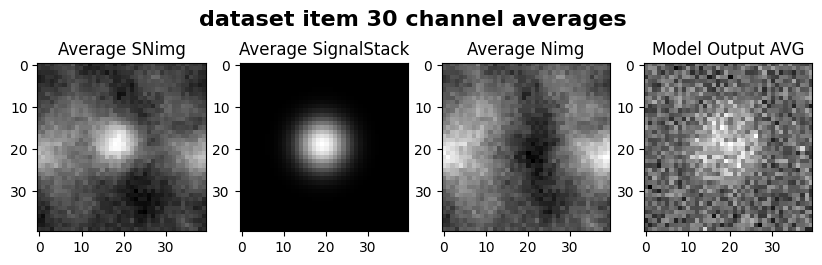

Epoch [1/20], Loss: 0.1865


<Figure size 640x480 with 0 Axes>

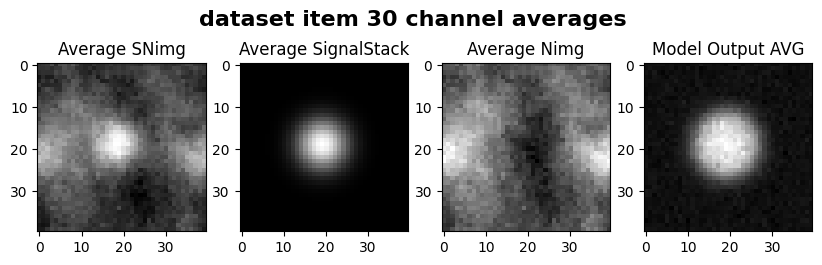

Epoch [2/20], Loss: 0.1031


<Figure size 640x480 with 0 Axes>

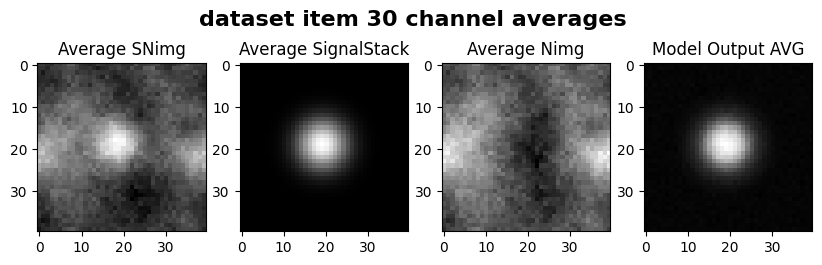

Epoch [3/20], Loss: 0.0390


<Figure size 640x480 with 0 Axes>

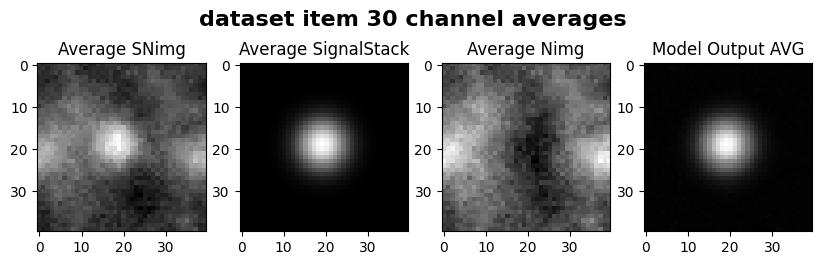

Epoch [4/20], Loss: 0.0206


<Figure size 640x480 with 0 Axes>

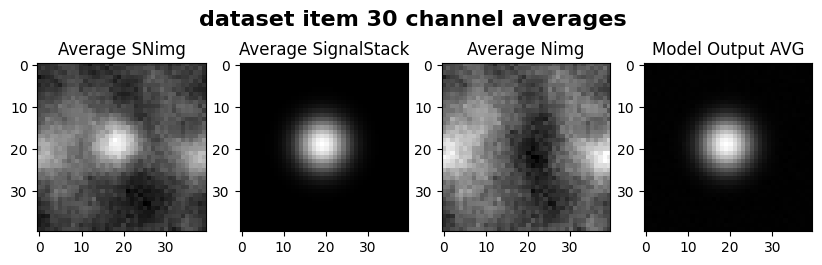

Epoch [5/20], Loss: 0.0153


<Figure size 640x480 with 0 Axes>

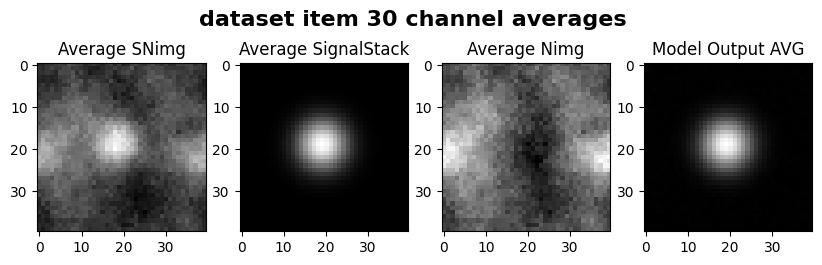

Epoch [6/20], Loss: 0.0118


<Figure size 640x480 with 0 Axes>

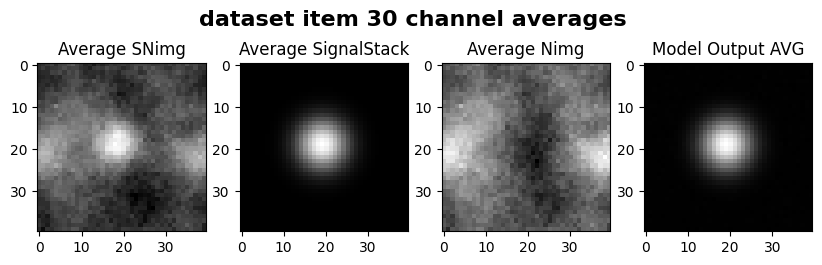

Epoch [7/20], Loss: 0.0090


<Figure size 640x480 with 0 Axes>

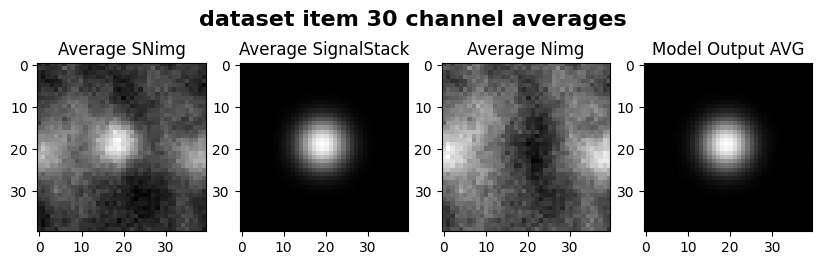

Epoch [8/20], Loss: 0.0062


<Figure size 640x480 with 0 Axes>

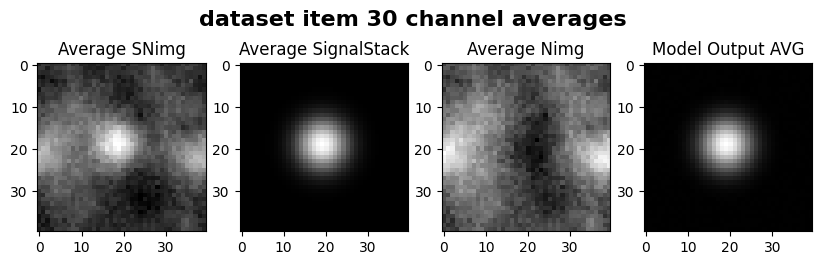

Epoch [9/20], Loss: 0.0066


<Figure size 640x480 with 0 Axes>

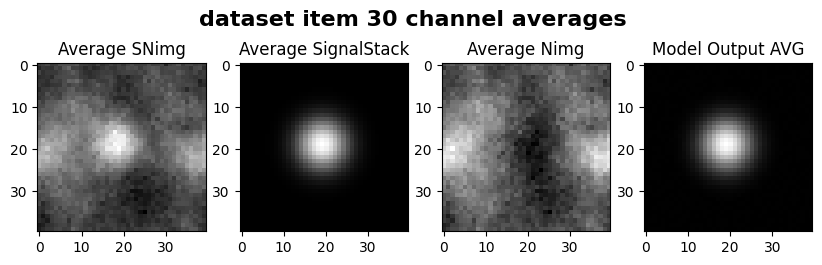

Epoch [10/20], Loss: 0.0047


<Figure size 640x480 with 0 Axes>

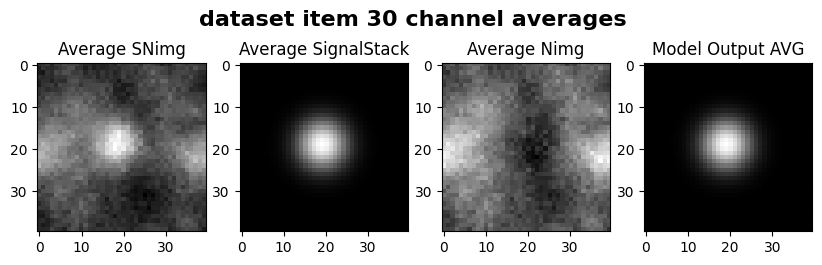

Epoch [11/20], Loss: 0.0056


<Figure size 640x480 with 0 Axes>

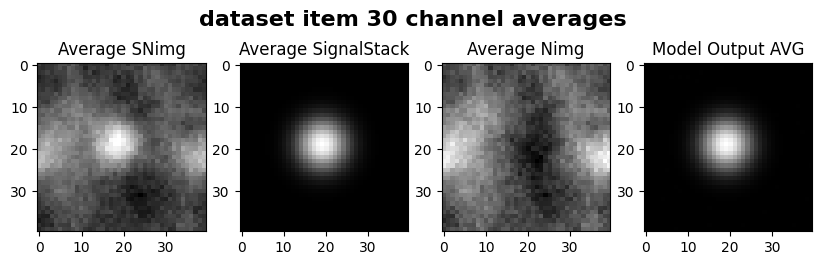

Epoch [12/20], Loss: 0.0044


<Figure size 640x480 with 0 Axes>

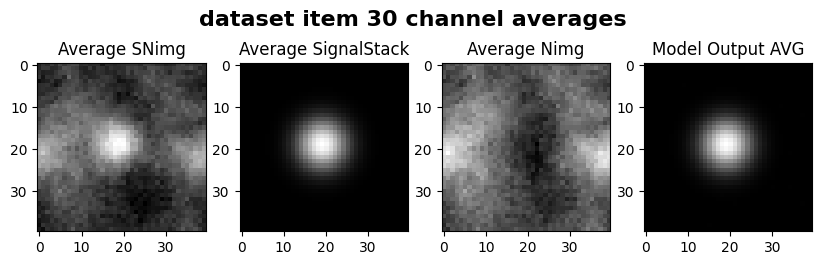

Epoch [13/20], Loss: 0.0044


<Figure size 640x480 with 0 Axes>

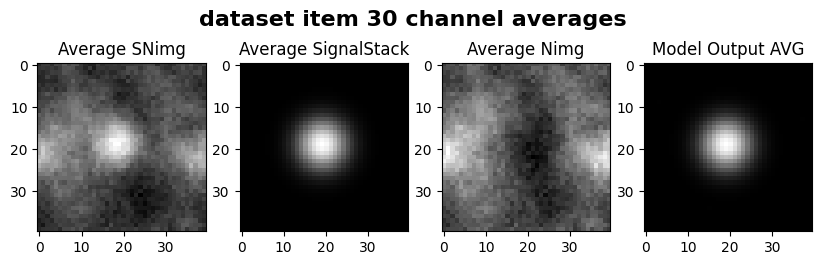

Epoch [14/20], Loss: 0.0040


<Figure size 640x480 with 0 Axes>

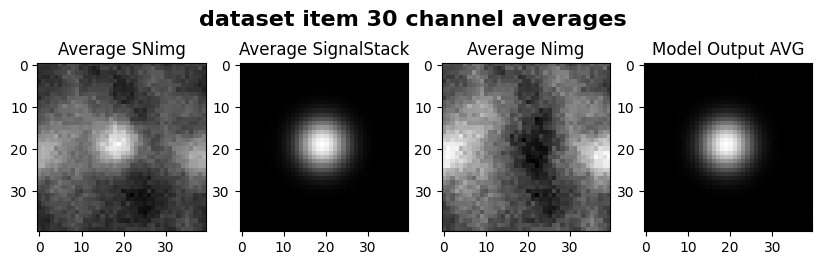

Epoch [15/20], Loss: 0.0040


<Figure size 640x480 with 0 Axes>

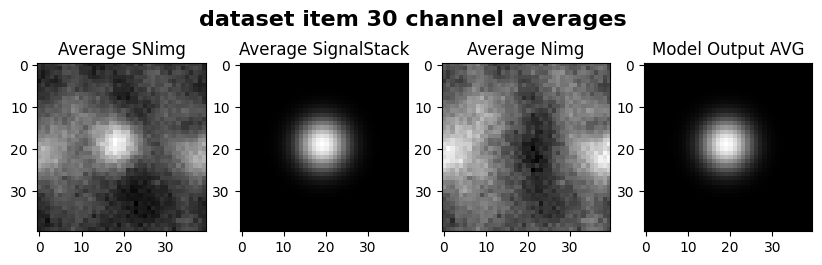

Epoch [16/20], Loss: 0.0035


<Figure size 640x480 with 0 Axes>

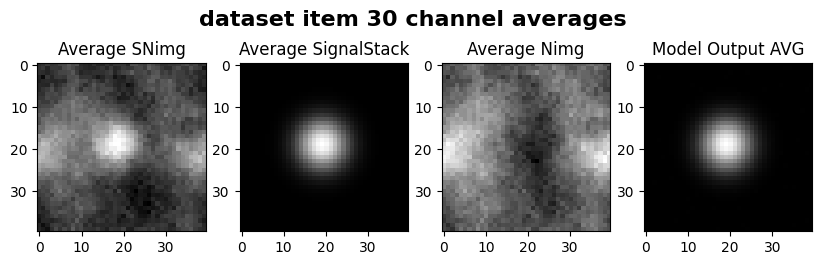

Epoch [17/20], Loss: 0.0041


<Figure size 640x480 with 0 Axes>

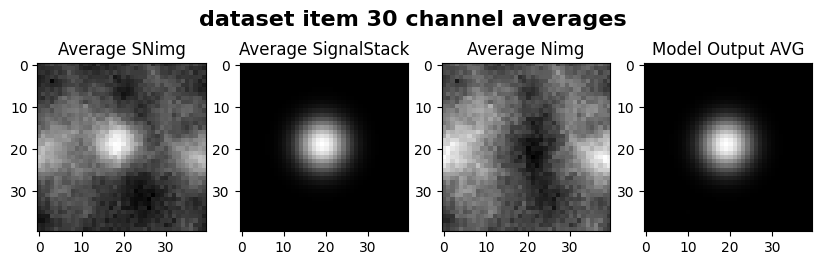

Epoch [18/20], Loss: 0.0043


<Figure size 640x480 with 0 Axes>

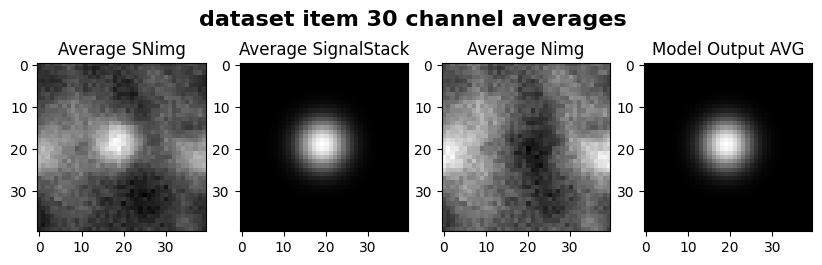

Epoch [19/20], Loss: 0.0042


<Figure size 640x480 with 0 Axes>

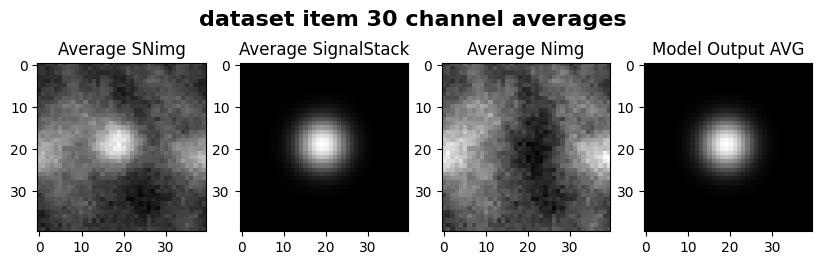

Epoch [20/20], Loss: 0.0049


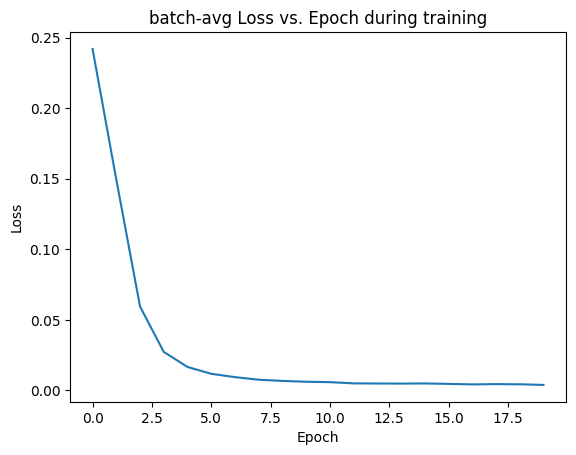

<Figure size 640x480 with 0 Axes>

In [11]:
#here is a code block which, after running cells above to define the class and functions, may be used to run the model from scratch
#simply point to the DATM_GATM root directory and provide parameters
##WHAT SHOULD HAPPEN
##image files in form of .grd in gatm/datm folders copied to PNG format & saved in pytorch compatible directory structure
##model is prepped and trained
##plots produced and saved which correspond to channel averages of the Signal+noise, residue, noise, and model(signal+noise) for each epoch/iteration of training
##final plot is produces to show convergence of loss vs epochs

#if one wishes to see more detail regarding how images look, how resampling of noise work, etc
#please use plotting functions such as 'SaveGIF_inROOT_SN_R_N' which produces a gif of all the channels of the stack of resampled noise Signal+Noise images
#or try to use some of the architecture of the 'trainModelFromScratch' function to step through things in more detail

#####################please specify folder where gatm/datm data folders are located
#DEFAULT_DATA_ROOTaddress =  'D:\\Research\\Yuri Fialko\\finalTesting\\'
#C:\Users\lukef\Google Drive\UCSD\research\SIO\Yuri Fialko\APS_removal_via_Pytorch_ViT
DEFAULT_DATA_ROOTaddress =  'C:\\Users\\lukef\\Google Drive\\UCSD\\research\\SIO\\Yuri Fialko\\APS_removal_via_Pytorch_ViT\\'

#image parameters
imgDim = [40,40,1]
train_test_ratio = 0.8
setting = 'DATM_GATM'
# Define the model parameters
image_size = (imgDim[0], imgDim[1])  #match to host dataset
patch_size = (10, 10)  #pixel size of patches used for feature embedding
dim = 256  # dimensionality of the token embeddings which are extracted from the patches
depth = 6 #number of transformer layers in the model, deeper models encode the image data further so capture more complex features
heads = 8 #number of attention heads in the multi-head self-attention mechanism. Each head attends to different parts of the input sequence, allowing the model to capture diverse patterns and relationships
mlp_dim = 512  #dimension of the feed-forward neural network (multi-layer perceptron) within the transformer block. This network processes the output of the self-attention mechanism. increase for more complexity
Multiplicity = 24    #this resamples spatial noise in image to simulate effect of CSS image stacking, treat Multiplicity as number of images in time sequence with new random noise each time
channels = Multiplicity  #this is redundancy, but wanted to keep the naming conventions of the pytorch functions intact to a certain degree, images with multiplicity = N have their tensors extended from (batchNum, channel=1, height, width) to (batchNum, channel=Multiplicity, height, width) such that the ML network is experiencing time sequences of data
dim_head = 64 #dimension of each attention head. It determines how the attention mechanism splits the input embeddings. A common choice is 64, but it can vary based on the specific architecture and problem
num_epochs = 20  #number of training epochs (training loops)
BatchNum = 50   #how many images are used in each batch of training
LearnRate = 0.001 #how quickly or slowly does model training try to move around, step size around learning space
intermediateIDX = 30 #which image from the training set is used for the example plots, the channel averages of SNimg, SignalStack, Nimg, and model(SNimg)

trainModelFromScratch(DEFAULT_DATA_ROOTaddress, imgDim, train_test_ratio, setting, image_size, patch_size, dim, depth, heads, mlp_dim, Multiplicity, channels, dim_head,num_epochs, LearnRate, BatchNum, intermediateIDX)
  

below is code cells where the user may continue coding or testing things      
in other words more freeform cells, a few examples provided but otherwise one may proceed to "what's next" section    

In [ ]:
#code to make gifs of all the training images where gif scans across noise-resampled channels of image

trainDataLengthLuke = 400

for i in range(0,trainDataLengthLuke):
    SaveGIF_inROOT_SN_R_N(i)

#if one is done training and wants to load in a previously trained model try      
loadTrainedModel(rootDir, modelFilename)

testing code for a model not inside of a function

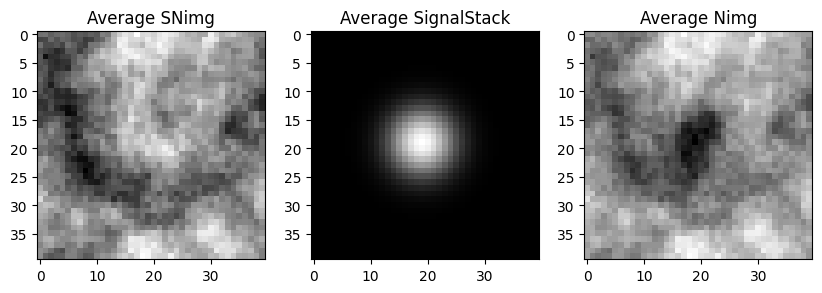

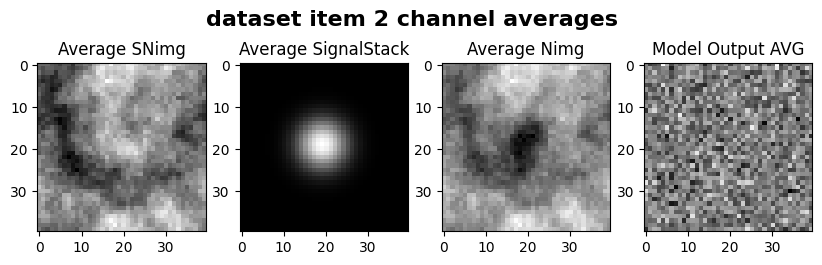

<Figure size 640x480 with 0 Axes>

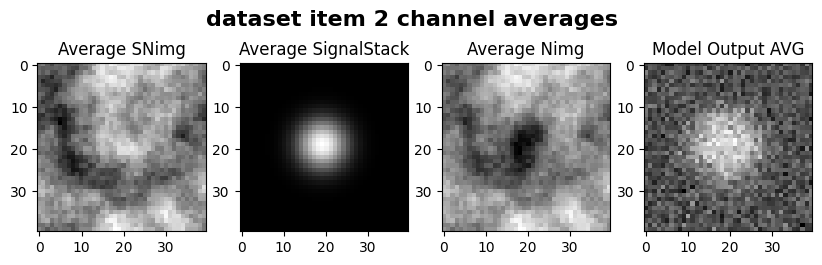

Epoch [1/20], Loss: 0.1841


<Figure size 640x480 with 0 Axes>

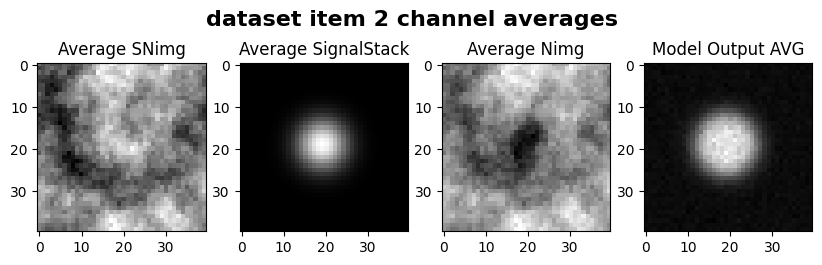

Epoch [2/20], Loss: 0.0917


<Figure size 640x480 with 0 Axes>

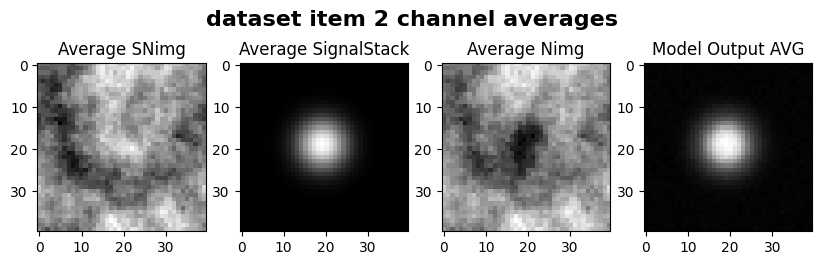

Epoch [3/20], Loss: 0.0339


<Figure size 640x480 with 0 Axes>

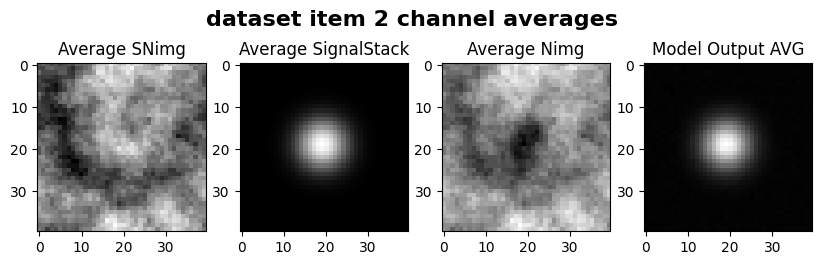

Epoch [4/20], Loss: 0.0230


<Figure size 640x480 with 0 Axes>

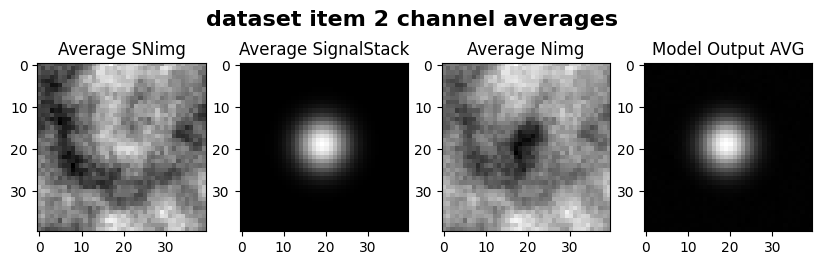

Epoch [5/20], Loss: 0.0144


<Figure size 640x480 with 0 Axes>

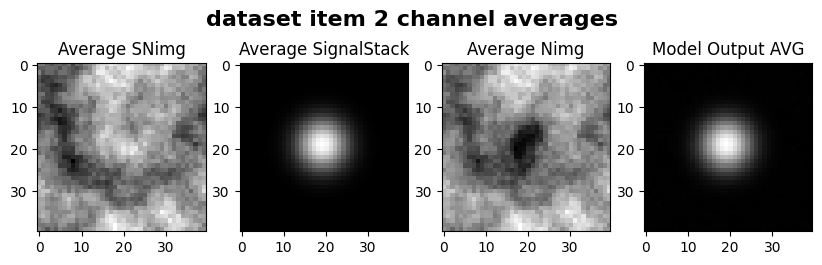

Epoch [6/20], Loss: 0.0117


<Figure size 640x480 with 0 Axes>

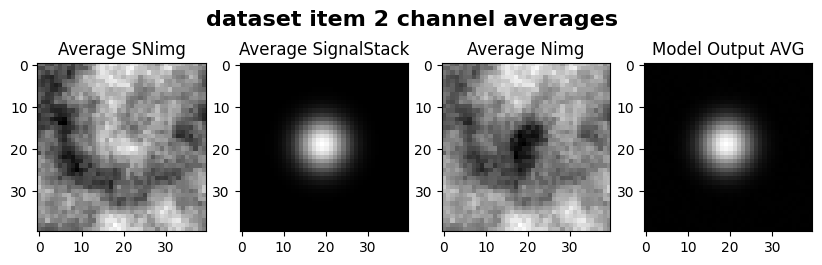

Epoch [7/20], Loss: 0.0085


<Figure size 640x480 with 0 Axes>

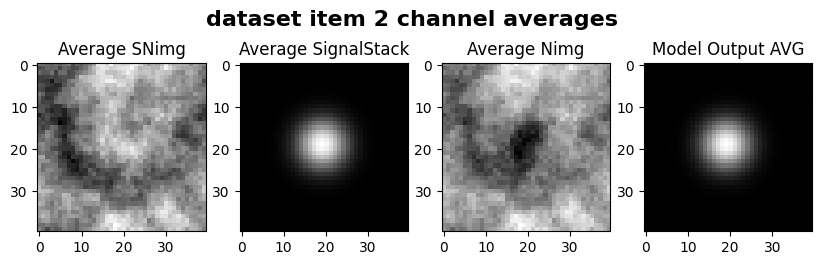

Epoch [8/20], Loss: 0.0095


<Figure size 640x480 with 0 Axes>

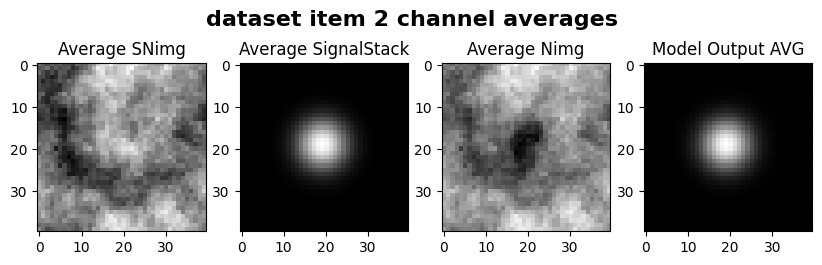

Epoch [9/20], Loss: 0.0059


<Figure size 640x480 with 0 Axes>

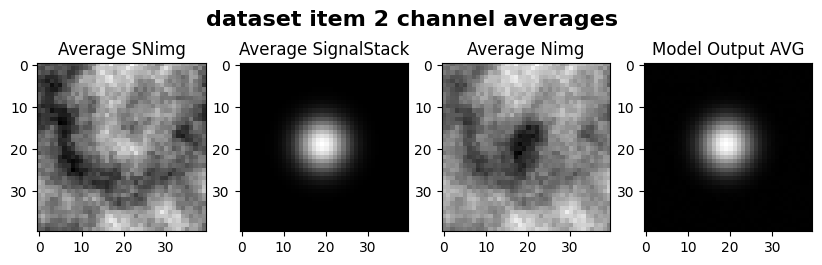

Epoch [10/20], Loss: 0.0054


<Figure size 640x480 with 0 Axes>

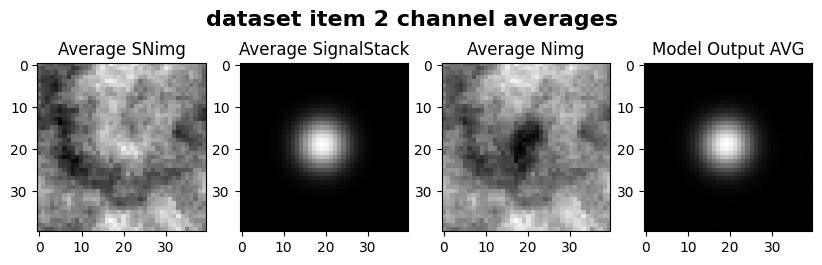

Epoch [11/20], Loss: 0.0146


<Figure size 640x480 with 0 Axes>

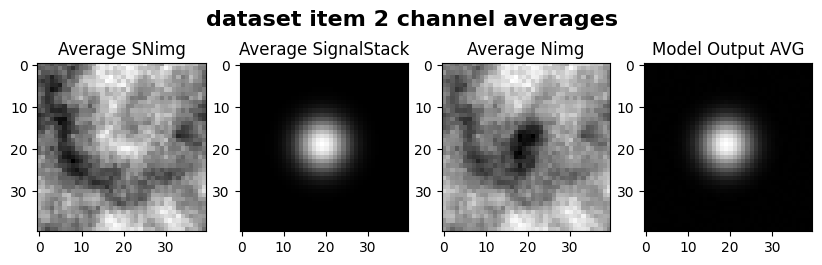

Epoch [12/20], Loss: 0.0100


<Figure size 640x480 with 0 Axes>

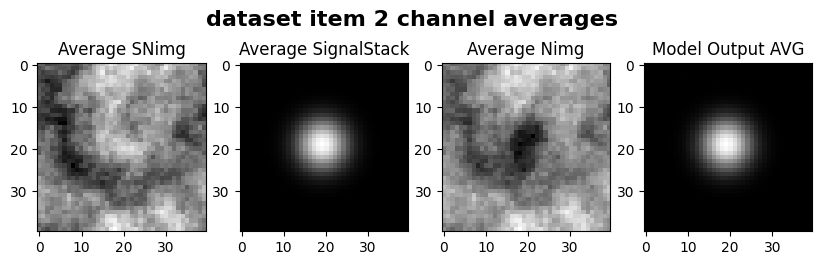

Epoch [13/20], Loss: 0.0080


<Figure size 640x480 with 0 Axes>

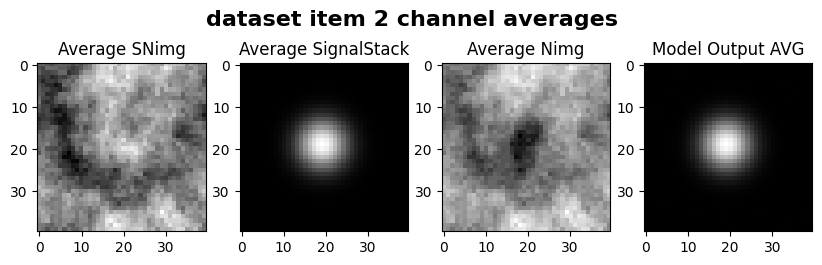

Epoch [14/20], Loss: 0.0086


<Figure size 640x480 with 0 Axes>

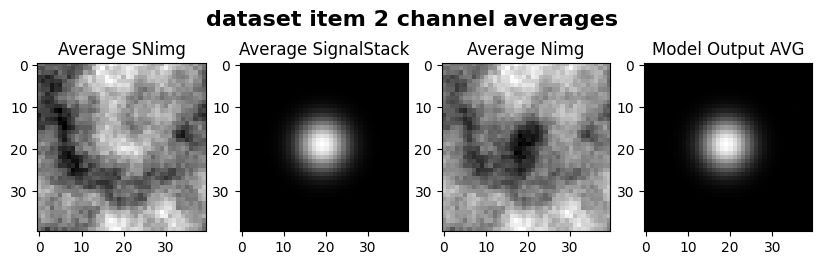

Epoch [15/20], Loss: 0.0077


<Figure size 640x480 with 0 Axes>

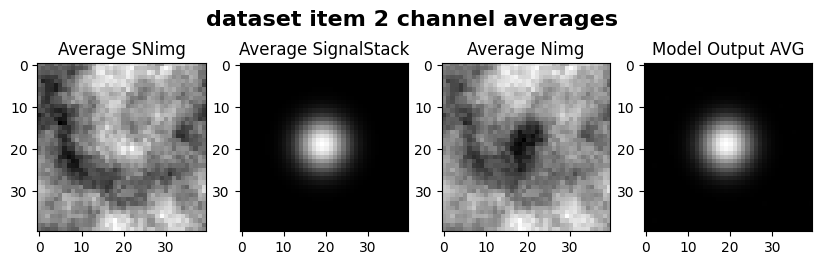

Epoch [16/20], Loss: 0.0073


<Figure size 640x480 with 0 Axes>

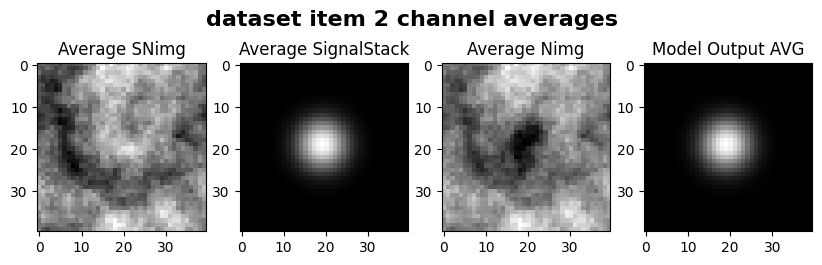

Epoch [17/20], Loss: 0.0075


<Figure size 640x480 with 0 Axes>

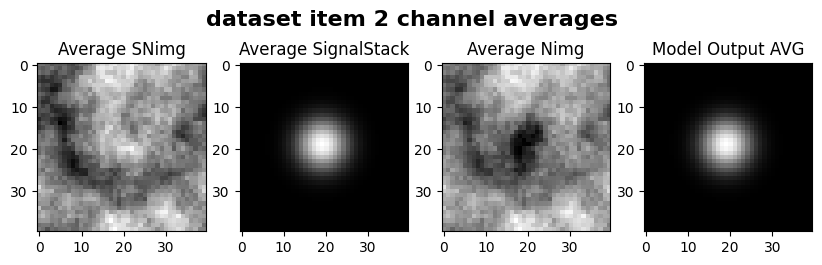

Epoch [18/20], Loss: 0.0066


<Figure size 640x480 with 0 Axes>

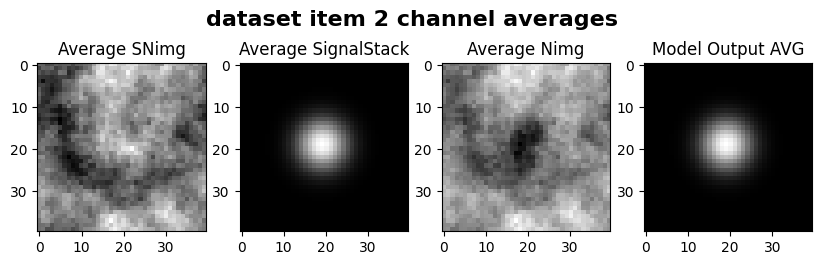

Epoch [19/20], Loss: 0.0063


<Figure size 640x480 with 0 Axes>

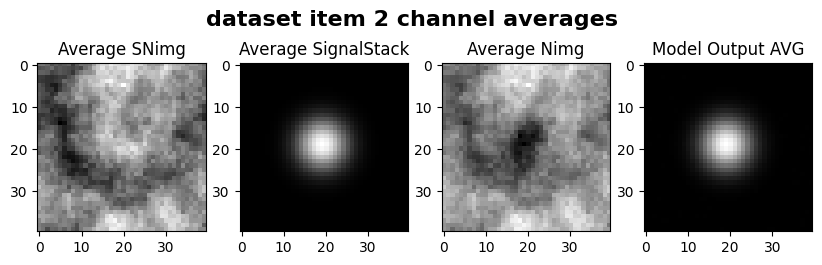

Epoch [20/20], Loss: 0.0045


<Figure size 640x480 with 0 Axes>

In [12]:
#timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
#loaderFULL(DEFAULT_DATA_ROOTaddress, imgDim, train_test_ratio, setting)
# Create an instance of the SimpleViT model
model = SimpleViTaps(image_size=image_size,patch_size=patch_size,dim=dim,depth=depth,heads=heads,mlp_dim=mlp_dim,channels=channels,dim_head=dim_head)
#transformation initially applied to each sample image as it is fetched by 
transformAPS = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),])
#set up dataset object and dataloader
Classified_APS_Path = DEFAULT_DATA_ROOTaddress + 'Png_n_sn_r\\'
Classified_APS_Dataset = CustomDatasetAPS(root_dir=Classified_APS_Path, transform=transformAPS, multiplicity = Multiplicity)
train_loader = DataLoader(Classified_APS_Dataset, batch_size=BatchNum, shuffle=True,drop_last=True) 
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Define the loss function and optimizer
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=LearnRate)




#testing index used to check plotting functions, possible values [0,len(training_data)-1]
testIDX = 2

SaveGIF_inROOT_SN_R_N(testIDX)

plot_channelAVGs(testIDX)

#plot_channelAVGsVSmodel(testIDX, epochNum=0)  


plot_channelAVGsVSmodel(testIDX, epochNum = 0, dataSet = Classified_APS_Dataset, Model = model)

lossAVG = []
for epoch in range(num_epochs):
    model.train()
    lossEpoch = []
    for SN, R in train_loader:
        SN, R = SN.to(device), R.to(device)
        optimizer.zero_grad()
        outputs = model(SN)
        loss = torch.sqrt(criterion(outputs, R))
        loss.backward()
        optimizer.step()
            # Append the loss to the list of losses
        lossEpoch.append(loss.item())
    lossAVG.append(np.mean(lossEpoch))
    plot_channelAVGsVSmodel(testIDX, epochNum = epoch, dataSet = Classified_APS_Dataset, Model = model)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    #modelFilename = 'APSmodel_' + timestamp
    #torch.save(model, rootDir + modelFilename)

In [ ]:
#need code for organizing data, if data already prepped into root/train,test/class_0, class_1, class_2 directory structure you may move on to run ML code blocks past the next markdown cell

####this address is associated with the data
#
#EFAULT_DATA_ROOTaddress = 'D:\\Research\\Yuri Fialko\\finalTesting\\'

#image dimensions [x,y,channel], testing was [40,40,1]
#mgDim = [40,40,1]
#rain_test_ratio = 0.8
#etting = 'DATM_GATM' #change to 'RAW_CSS' in case of images which are Signal # noise and corresponding images of CSS stack average, 
#both should have dimensionality (height,width,channel=1), matching number of samples vs corresponding CSS images
#IN EITHER CASE, data should be in root/subdirectory corresponding to these naming conventions, namely 'datm/gatm/raw/css'
##datm - signal+noise
##gatm - noise
##raw - relatively unaltered images such as real examples from satellite
##css - way of replicating 'residue' images by utilizing CSS output that corresponds to the 'raw' output's interferometric fault line displacement signal

###load in and preprocess data from example datm/gatm provided
#oaderFULL(DEFAULT_DATA_ROOTaddress, imgDim, train_test_ratio, setting)
#what should happen is that images are organized into root/train,test/class_0, class_1, class_2 where class 0 is residues, class 1 is signal+noise, class 2 is noise
#this is the directory structure expected by pytorch dataloader
#can simply modify code to create new subdirectory 'valid' and populate it with some of the data by modifying code in previous function block^

Recommendations for next steps:     

-hyperparameter optimization such as by grid search over order of magnitude ranges, or more sophisticated methods such as differential evolution, MCMC, outer layer of loss optimization training, etc...       
---Note: below are some more easily identifiable from pytorch architecture, but some other hyperparams exist within code which are important such as 'multiplicity'           
---learning rate => how quickly or slowly does model training try to move around, step size around learning space. not finding global optimum need to increase, if can't quite fall down into nice stable spot need to slow down/decrease       
---batch size =>   how many images are used in each batch during training     
---epochs  => how many training loops run, increase if want to converge more     
---loss function or loss ensemble(torch MSE used)         
---optimizer(Adam used)       
---patch_size => how large are the moving windows of the transform which encodes the pixel data into features? NEEDS TO FIT NEATLY IN IMAGE ie no remainder between img/patch  
---dim => dimensionality of the token embeddings which are extracted from the patches     
---depth => number of transformer layers in the model, deeper models encode the image data further so capture more complex features     
---heads => number of attention heads in the multi-head self-attention mechanism. Each head attends to different parts of the input sequence, allowing the model to capture diverse patterns and relationships     
---mlp_dim => dimension of the feed-forward neural network (multi-layer perceptron) within the transformer block. This network processes the output of the self-attention mechanism. increase for more complexity      
---channels => THIS SHOULD BE 'channels = multiplicity', see multiplicity section below     
---dim_head => dimension of each attention head. It determines how the attention mechanism splits the input embeddings. A common choice is 64, but it can vary based on the specific architecture and problem   

-insert model validation   
---model currently has a rudimentary training loop, but some methods such as validation can be added to make model more robust & generalizable

-modify ViT model       
---much of the code provided in the folder is not strictly necessary to run my model, it is example code from https://github.com/lucidrains/vit-pytorch project       
---the main reason I want to include this is because the authors do an exhaustive meta analysis of different ViT architectures, their github links to many of the papers which established these different models       
---there are tons of models to try using & potentialy some maybe deal with APS removal particularly well, at least better than the simpleVIT used in development     
---the model I used in development and testing is a modified version of their 'SimpleViT.py'       
---the changes I made are as follows:       
---rather than classification, my model tries to find the signal in the noise       
---it uses 'self.linear_head = nn.Linear(self.dim, self.channels * self.image_height * self.image_width)' to output the transformed image tensor back to a tensor of the same original shape, to then be compared against the true residual image in the loss function during training (loss is nn.MSELoss())     
---NOTE that the linear head method must be defined & called upon in the forward pass       
---some other tweaks are small like no need to use num_classes stuff     
---if a new model is not modified from classification to transform, issues of dimensionality will pop up when loss(model(input), residue) is called  
---the classifier models return outputs with dimensionality (batchNum, classVec) to be compared with a TrueClassVec during classification tasks whereas my filtering model returns outputs with same dimensionality as original images ie (batchNum, channels, height, width) via the linear head change       
------If I were messing around with different model examples, which I would likely do in the short term rather than long term of the project, I would try to reshape all/many ViT examples from github examples to the task of filtration/transform as done with the simple model and then use a dict to organize them within the function call for training, meaning use model as another parameter in the training/testing/use function call  
-----for meta-analysis purposes and use in more complex systems since certains models might convey different advantages   
-----could also use them for some sort of classification task such as classifying whether or not a signal is magnitude 0,1,2,...    
-----or other tasks, please refer to https://github.com/lucidrains/vit-pytorch project for more info     

-modify initial data transform    
---[still need to rename the initial transformation other than transformMine]
---this transform is initially applied to the data upon loading with the [CustomDatasetMine], which is when algo looks for subdirectories 'train/test' with parallel sub-sub directories 'class_0/class_1/2/3....']  
---all this transform really does now is make sure the image_size parameters enforced by user input are holding with images   
---and transform the images into tensors  
---however; MANY transforms exist which may be easily applied to the images by simply adding some code along the lines of https://pytorch.org/vision/stable/transforms.html  
---these transforms may serve as incredible ways to pre-process the data, generalize the model, and optimize performance  
---if it were me  
---I would test implementing different transforms   
---optimize loss around them via an outer training loop over hyperparams such as ones associated with these transforms   
---eventual goal of having some ensemble model which can deal with data that has been transformed in different ways from simple rotations to warping or other phenomena which are related to image defects in the real use case datasets   


-modify test dataset from MATLAB fake_igrams code       
---scale up images, save results, use to see how well model deals with data scaling       
---make very large batches for larger testing runs for continued training       
---vary shape of signal to make sure model isn't overfitting to gaussian bump or something, this is realistically addressed by true-signal training though, see below        

-use on real data, best model for task will be one trained as close to real conditions as possible       
---[advice on how to import data differently, need to design it in such a way that gatm & datm are used as root]       
---I'm going to try to make it where you may simply point to the root folder of data, specifically one with 'datm' 'gatm' folders ie outpout of fake_igrams.m code & autoprocess data & prep for training     
---the main thing that needs to happen to code if not loading correctly: training data loader objects expect directory structure of root/train/class_#   
---where you may have train/valid/test subdirectories from root, then within those have class_0/class_1/....      
---these classes were used to organize data for model, in my code class_0 is residue images, class_1 is signal and noise, class_2 is noise     
---my goal with code is to make it where you may simple point to root with datm & gatm, then code will organize that folder structure for training     
---[speaking of validation code and samples, they]       
---when training on real data, would maybe use trustworthy CSS to approximate real signal, this would serve as 'Residue' in model & training ie. thing which is being compared in loss function against model(Signal+Noise)     
---then for real use would want to simply save model parameters and structure then call as model(Signal+Noise_real) => model's best guess at what persistent signal looks like     

-modify multiplicity parameter       
---(relevant code CustomDatasetMine.multiNoise & CustomDatasetMine.SignalStack)       
---multiplicity is effectively a method of using CSS methodology        
---when you make multiplicity = n (integer), the 1-channel image input is turned into a n-channel image where pixel noise has been resampled for each new channel       
---the STD of the original Signal_and_Noise image is extracted via 'torch.std(SNimg)'       
---then the noise is resampled/overlaid with new noise layer via 'torch.randn(self.multiplicity, *SNimg.shape)'       
---such that the image from get_item has channels = multiplicity & each new channel has resampled noise     
---I hope this procedure is fine to resample noise, I figured it wasn't too much of issue since can tune parameters of original MATLAB file noise or tune scaling of these new noise layers by tuning the parameters of the functions I showed above^       
---the residue signal (SignalNoise - Noise) does not resample noise since it's variations are miniscule, in other words signal is relatively long lasting/ persistent feature in image. Residue is simply extended to the new channel number w/ 'return Rimg.unsqueeze(1).expand(-1, self.multiplicity, -1, -1).squeeze(0)'     
---the whole point of this multiplicity?       
---simulate having a long lasting signal with each (time) snapshot resampling short timescale noise       
---the idea being that in the use case of real-time satellite images we may simply take 'multiplicity' parameter to tell us how many of the previous snapshots to use in a stacked image object, keep old images in moving window       
---essentially take advantage of CSS methodology to show model the signal since it's time persistence is the main difference we want model focused on wrt noise vs signal        
---should be helpful for direct comparison of standardized CSS vs this model, ie. multiplicity is stand-in for 'stackNum' in CSS       

-modify noise level to test robustness to variable noise       
---scaling w/ a multiplicative parameter, train model on variable noise to keep it robust, but focus on real signal operating range     
---form: current implementation is 'torch.randn(self.multiplicity, *SNimg.shape)'  with 'torch.std(SNimg)'  as noise scaling, please refer to CustomDatasetMine.multiNoise for noise modification     

-compartmentalize code further       
---this may depend on use case, but generally wrapping code blocks into functions or classes & importable files to enable implementation in other systems       

-if computational power is needed consider cuda core or other hardware changes to help with training on high resolution or high multiplicity        
---my device was able to handle development & testing, but as real data images come the model will need more compute to work with  

-Visualization   
---[I might have time to do some visualization codes]     

-Train on different task?  
---currently training is loss(model(SignalAndNoise), Residue)  
---but maybe the model could be trained on a different task or multiple tasks?   
---such as loss(model(SignalAndNoise), Noise)    
---or a multi loss system  

-Generative adversarial network  
---train one model to produce noise as mentioned above in 'different tasks'^    
---then set up system where generative model produces new noise overlays or new signals    
---then set up a GAN loop between generative network and discriminator network  
---might help explore wider state space of possible noise and increase generalizability/robustness  


-  
-  
- 
